In [ ]:
# Importing and installing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier

!pip install graphviz
import graphviz as gv

In [ ]:
# Read data into pandas dataframe
df = pd.read_csv('https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true')

# Save a Copy
data = df.to_csv('census-data.csv', index=False)


# Initial Observation of df architecture and types
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


In [ ]:
# Now we need to split the data into training and testing sets based on the 'flag' column
train_data = df[df['flag'] == 'train'].drop('flag', axis=1)
test_data = df[df['flag'] == 'test'].drop('flag', axis=1)

In [ ]:
#encode categorigal varaibles in train_data and test_data
train_data = pd.get_dummies(train_data, drop_first=True)
test_data = pd.get_dummies(test_data, drop_first=True)

X_train = train_data.drop('y', axis=1)
y_train = train_data['y']

X_test = test_data.drop('y', axis=1)
y_test = test_data['y']


# Finding Optimal Value for n_estimators - Random Forest Classifier

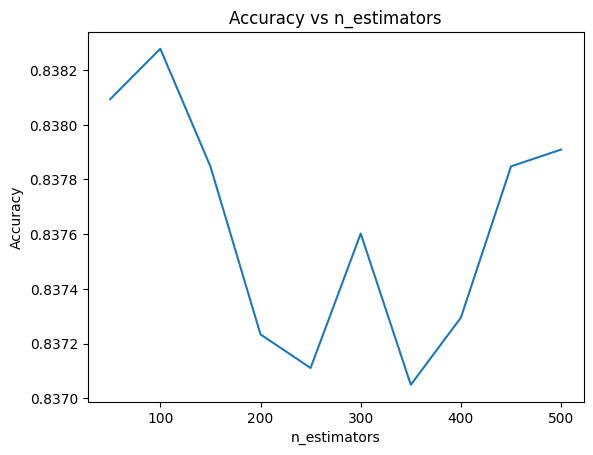

In [ ]:
# Accuracy vs. n_estimators

results = []
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
max_accuracy = 0  # Initialize the max_accuracy variable

for i in n_estimators:
    model = RandomForestClassifier(n_estimators=i, random_state=101)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)

    # Update the max_accuracy variable if the current accuracy is higher
    if accuracy > max_accuracy:
        max_accuracy = accuracy

plt.plot(n_estimators, results)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs n_estimators')
plt.show()

Observations about the Classifier’s behavior with respect to the number of estimators:

- Between 50 and 100 estimators, accuracy values increases significantly but drops significantly from 0.8383 to 0.8371 when the number of estimators falls between 100 and 250. Between 250 and 300 estimators, the accuracy increases from 0.8371 to 0.8376 but drops again between 300 to 350 estimators. The accuracy increases significantly from 0.83705 to 0.8379 between 350 and 450 estimators and slowly increases from 450 to 500 estimators.

Optimal value of the estimator within the given range: 100.

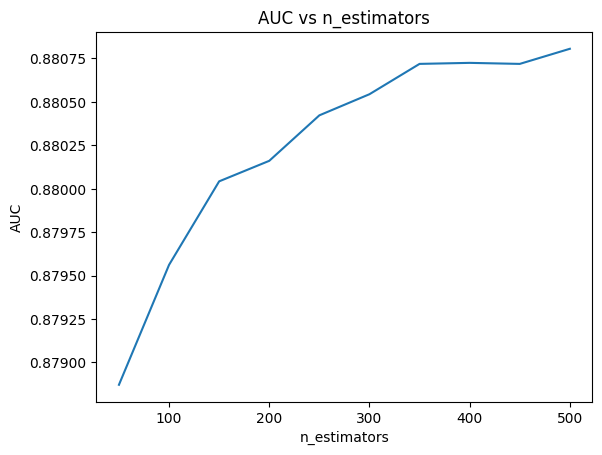

In [ ]:
# AUC vs. n_estimators
results = []
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
max_auc = 0  # Initialize the max_auc variable

for i in n_estimators:
    model = RandomForestClassifier(n_estimators=i, random_state=101)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # get probabilities for the positive class
    auc = roc_auc_score(y_test, y_pred_proba)
    results.append(auc)

    # Update the max_auc variable if the current AUC is higher
    if auc > max_auc:
        max_auc = auc

plt.plot(n_estimators, results)
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.title('AUC vs n_estimators')
plt.show()

Observations about the Classifier’s behavior with respect to the number of estimators:

- Between 50 and around 150 estimators, AUC values increases significantly. Between 150 and 350 estimators, AUC values increases but more steadily then before. However, the model performance starts to saturate between 350 and 500 estimators as the area of AUC barely increases with more estimators.

Optimal value of the estimator within the given range: 350.

# AdaBoost, Gradient Boost, and XGB

In [ ]:
!pip install scikit-learn xgboost matplotlib

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt


In [ ]:
X_train.columns

Index(['hours_per_week_bin_b. 31-40', 'hours_per_week_bin_c. 71-100',
       'hours_per_week_bin_d. 41-50 & 61-70', 'hours_per_week_bin_e. 51-60',
       'occupation_bin_b. Mid - Low', 'occupation_bin_c. Mid - Mid',
       'occupation_bin_d. Mid - High', 'occupation_bin_e. High',
       'msr_bin_b. Mid', 'msr_bin_c. High', 'capital_gl_bin_b. < 0',
       'capital_gl_bin_c. > 0', 'race_sex_bin_b. Mid', 'race_sex_bin_c. High',
       'education_num_bin_b. 9-12', 'education_num_bin_c. 13',
       'education_num_bin_d. 14', 'education_num_bin_e. 15+',
       'education_bin_b. Mid', 'education_bin_c. Bachelors',
       'education_bin_d. Masters', 'education_bin_e. High',
       'workclass_bin_b. income', 'age_bin_b. 26-30 & 71-100',
       'age_bin_c. 31-35 & 61-70', 'age_bin_d. 36-40 & 56-60',
       'age_bin_e. 40-55'],
      dtype='object')

In [ ]:
X_train.columns = [cname.replace('[', '').replace(']', '').replace('<', '') for cname in X_train.columns]
X_test.columns = [cname.replace('[', '').replace(']', '').replace('<', '') for cname in X_test.columns]

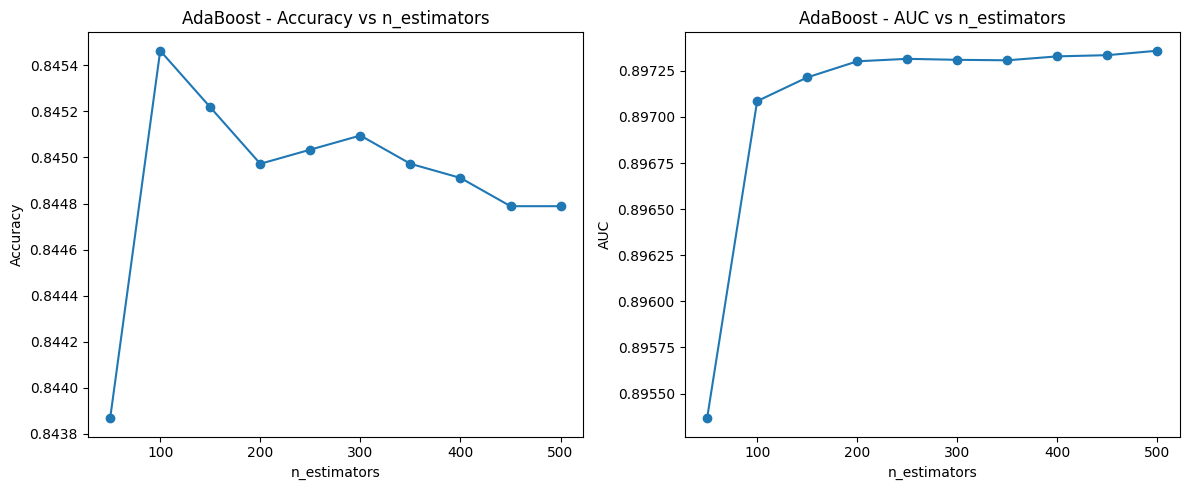

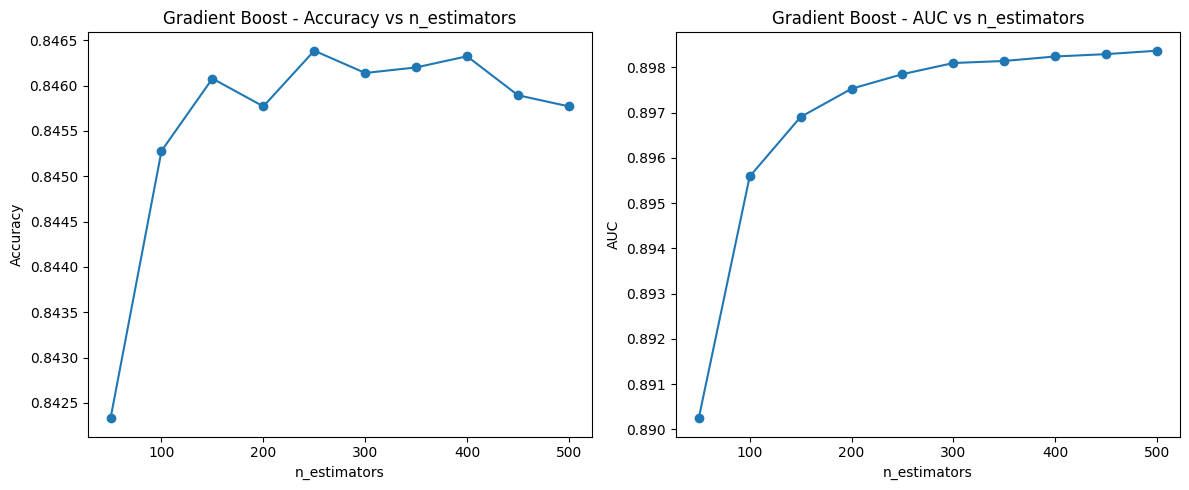

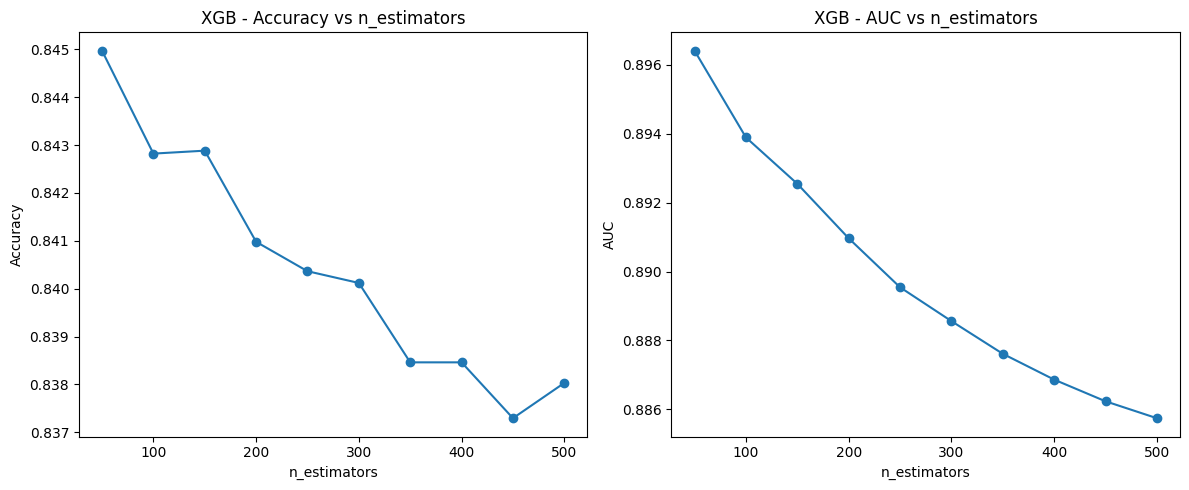

In [ ]:
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
models = {
    'AdaBoost': AdaBoostClassifier,
    'Gradient Boost': GradientBoostingClassifier,
    'XGB': XGBClassifier
}

# Dictionary to store the best scores for each model
best_scores = {}

# Iterate over models
for name, Model in models.items():
    acc_results = []
    auc_results = []
    best_accuracy = 0  # Initialize best accuracy for this model
    best_auc = 0  # Initialize best AUC for this model

    # Iterate over different values of n_estimators
    for i in n_estimators:
        model = Model(n_estimators=i, random_state=101)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        # Check if this accuracy is the best for this model, if so update best_accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy

        # Check if this AUC is the best for this model, if so update best_auc
        if auc > best_auc:
            best_auc = auc

        acc_results.append(accuracy)
        auc_results.append(auc)

    # Store the best scores for this model in the dictionary
    best_scores[name] = {'best_accuracy': best_accuracy, 'best_auc': best_auc}

    # Plotting
    plt.figure(figsize=(12, 5))

    # Accuracy vs. n_estimators
    plt.subplot(1, 2, 1)
    plt.plot(n_estimators, acc_results, marker='o')
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.title(f'{name} - Accuracy vs n_estimators')

    # AUC vs. n_estimators
    plt.subplot(1, 2, 2)
    plt.plot(n_estimators, auc_results, marker='o')
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title(f'{name} - AUC vs n_estimators')

    plt.tight_layout()
    plt.show()


AdaBoost - Accuracy vs n_estimator:
    
Observations about the Classifier’s behavior with respect to the number of estimators:

- Between 50 and around 100 estimators, accuracy values increases significantly from 0.84385 to 0.84546. Between 100 and 500 estimators, we can observe a downward trend for accuracy values from 0.84545 to 0.8448.

Optimal value of the estimator within the given range: 100.

AdaBoost - AUC vs n_estimator:
    
Observations about the Classifier’s behavior with respect to the number of estimators:

- Between 50 and around 100 estimators, accuracy values increases significantly from around 0.89520 to 0.89710. Between 100 and 200 estimators, AUC values has a slow increase from around 0.89710 to 0. 89730. Then AUC values plateaus between 200 and 500 estimators.

Optimal value of the estimator within the given range: 200.

Gradient Boost - Accuracy vs n_estimator:
    
Observations about the Classifier’s behavior with respect to the number of estimators:

- Between 50 and around 100 estimators, accuracy values increases significantly from around 0.84235 to 0.8457. Between 100 and around 250 estimators, we can observe a upward trend for accuracy values from 0.84525 to 0.8464. Between 250 and 500 estimators, we can observe a downward trend from 0.8464 to 0.84575.

Optimal value of the estimator within the given range: 250.

Gradient Boost - AUC vs n_estimator:
    
Observations about the Classifier’s behavior with respect to the number of estimators:

- Between 50 and around 100 estimators, AUC values increases significantly to 0.8956. Between 100 and around 300 estimators, AUC values increases from 0.8956 to around 0.898 but starts to plateau between 300 and 500 estimators.

Optimal value of the estimator within the given range: 300.

XGB - Accuracy vs n_estimator:
    
Observations about the Classifier’s behavior with respect to the number of estimators:

- Between 50 and 450 estimators, we can observe a downward trend for accuracy values as it drops from 0.845 to 0.8375. Between 450 and 500 estimators, accuracy values increases to 0.838.

Optimal value of the estimator within the given range: 50.

XGB - AUC vs n_estimator:
    
Observations about the Classifier’s behavior with respect to the number of estimators:

- Between 50 and 500 estimators, we can observe a significant downward trend of AUC values from 0.8964 to 0.886.

Optimal value of the estimator within the given range: 50.



In [ ]:
best_scores

{'AdaBoost': {'best_accuracy': 0.8454640378355138,
  'best_auc': 0.8973591850791041},
 'Gradient Boost': {'best_accuracy': 0.8463853571647934,
  'best_auc': 0.898366283666224},
 'XGB': {'best_accuracy': 0.8449726675265647, 'best_auc': 0.8964087200399958}}

**Best Accuracy and AUC for each Model**

In [ ]:
# Headers for the table
print(f"{'Model':<15}{'Random Forest':<15}{'AdaBoost':<15}{'Gradient Boost':<15}{'XGB':<15}")

# Printing Accuracy
accuracy_str = "Accuracy       "
for model in ["Random Forest", "AdaBoost", "Gradient Boost", "XGB"]:
    if model == "Random Forest":
        accuracy_str += f"{max_accuracy:<15.3f}"
    else:
        accuracy_str += f"{best_scores[model]['best_accuracy']:<15.3f}"
print(accuracy_str)

# Printing AUC
auc_str = "AUC            "
for model in ["Random Forest", "AdaBoost", "Gradient Boost", "XGB"]:
    if model == "Random Forest":
        auc_str += f"{max_auc:<15.3f}"
    else:
        auc_str += f"{best_scores[model]['best_auc']:<15.3f}"
print(auc_str)

Model          Random Forest  AdaBoost       Gradient Boost XGB            
Accuracy       0.838          0.845          0.846          0.845          
AUC            0.881          0.897          0.898          0.896          
